In [1]:
import sys
import os

# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import asdict, is_dataclass, dataclass
from pandas.api.types import is_datetime64_any_dtype
import scipy
import numpy as np
import polars as pl
from typing import Dict, List
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from src.common.AssetData import AssetData
from src.common.AssetDataPolars import AssetDataPolars
from src.common.AssetDataService import AssetDataService
from src.common.AssetFileInOut import AssetFileInOut 
from src.databaseService.OutsourceLoader import OutsourceLoader

from src.simulation.SimulatePortfolio import SimulatePortfolio
from src.strategy.StratBuyAndHold import StratBuyAndHold
from src.simulation.ResultAnalyzer import ResultAnalyzer
from src.common.AssetFileInOut import AssetFileInOut
from src.predictionModule.FourierML import FourierML
from src.common.DataFrameTimeOperations import DataFrameTimeOperationsPandas as DFTO


In [3]:
assets=AssetFileInOut("../src/stockGroups/bin").loadDictFromFile("group_snp500_over20years")

# Convert to Polars for speedup
assetspl: Dict[str, AssetDataPolars] = {}
for ticker, asset in assets.items():
    assetspl[ticker]= AssetDataService.to_polars(asset)

In [4]:
ticker ="MMM"
aIRM = assetspl[ticker]
pricesArray = aIRM.adjClosePrice["AdjClose"]
currDatediff = 500*5
aidx = len(pricesArray) - currDatediff
pastPrices = pricesArray.slice(aidx-24 * 21, 24 * 21 +1).to_numpy()

aIRM.adjClosePrice["Date"].item(aidx)

datetime.datetime(2014, 11, 19, 0, 0)

In [5]:
startTrainDate=pd.Timestamp(year=2019, month=1, day=4)
endTrainDate=pd.Timestamp(year=2019, month=2, day=4)
startTestDate=pd.Timestamp(year=2019, month=2, day=5)
fourierTestML = FourierML(assetspl, 
                trainStartDate = startTrainDate,
                 trainEndDate = endTrainDate,
                 testStartDate = startTestDate,
                 testEndDate= startTestDate+ pd.Timedelta(days=10))

fourierTestML.prepareData()

Processing asset: MMM.  Processed 0 out of 390.
Processing asset: AOS.  Processed 1 out of 390.
Processing asset: ABT.  Processed 2 out of 390.
Processing asset: ACN.  Processed 3 out of 390.
Processing asset: AES.  Processed 4 out of 390.
Processing asset: AFL.  Processed 5 out of 390.
Processing asset: A.  Processed 6 out of 390.
Processing asset: APD.  Processed 7 out of 390.
Processing asset: ALB.  Processed 8 out of 390.
Processing asset: ARE.  Processed 9 out of 390.
Processing asset: LNT.  Processed 10 out of 390.
Processing asset: ALL.  Processed 11 out of 390.
Processing asset: MO.  Processed 12 out of 390.
Processing asset: AEE.  Processed 13 out of 390.
Processing asset: AEP.  Processed 14 out of 390.
Processing asset: AXP.  Processed 15 out of 390.
Processing asset: AIG.  Processed 16 out of 390.
Processing asset: AMT.  Processed 17 out of 390.
Processing asset: AME.  Processed 18 out of 390.
Processing asset: APH.  Processed 19 out of 390.
Processing asset: AON.  Processed

In [6]:
metadata = {"data": "data"}
fourierTestML.save_data_with_metadata(".", "testSave.pkl", metadata)

Data and metadata saved to .\testSave.pkl


In [7]:
tempML = FourierML(assetspl, 
                trainStartDate = startTrainDate,
                 trainEndDate = endTrainDate,
                 testStartDate = startTestDate,
                 testEndDate= startTestDate+ pd.Timedelta(days=10))

tempML.load_data_with_metadata(".","testSave.pkl")
a=tempML.y_train
b=fourierTestML.y_train
m=tempML.metadata

Data and metadata loaded from .\testSave.pkl


C:\Users\KILightTouch\AppData\Local\Temp\ipykernel_16000\1543998254.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=fourierTestML.y_train, palette='viridis')


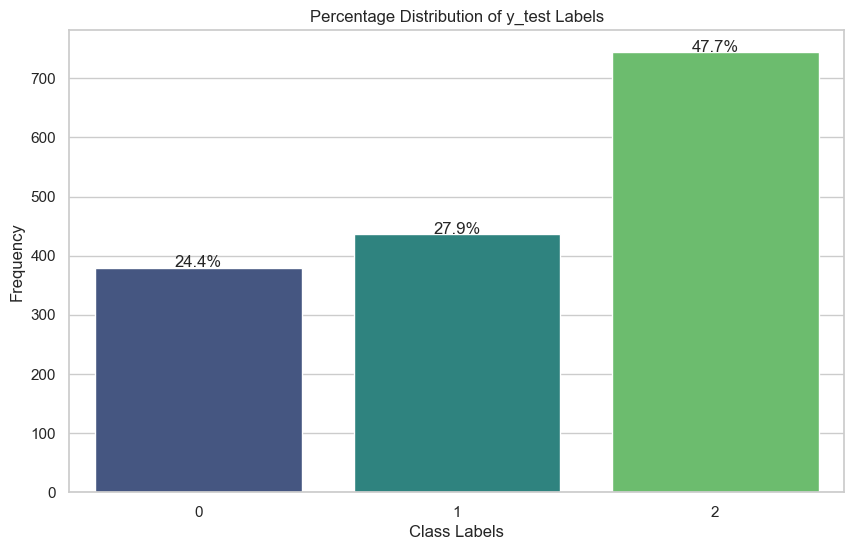

0.3649046679815911


In [8]:
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
total = len(fourierTestML.y_train)
sns.countplot(x=fourierTestML.y_train, palette='viridis')

# Add percentage labels on top of each bar
percentage= []
for p in plt.gca().patches:
    perc = '{:.1f}%'.format(100 * p.get_height() / total)
    percentage.append(p.get_height() / total)
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2., height + 1, perc, ha="center") 

plt.title('Percentage Distribution of y_test Labels')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.show()

percentage= np.array(percentage)
print(np.sum(percentage ** 2))

In [9]:
np.mean(fourierTestML.y_train)

1.2333333333333334

In [12]:
from sklearn.model_selection import train_test_split
from src.mathTools.RandomProjectionClassifier import RandomProjectionClassifier as rpc
X_val = fourierTestML.X_test
y_val = fourierTestML.y_test
X_train, X_test, y_train, y_test = train_test_split(fourierTestML.X_train, fourierTestML.y_train, test_size=.1)

# Initialize the classifier
fourierRPCModel = rpc(
    num_random_features=1000,
    regularization=30,
    max_iter=10,
    verbose=True,
    random_state=None
)
# Train the model
fourierRPCModel.fit(X_train, y_train)

fourierRPCModel.tune_regularization(X_test, y_test, low_start=1, high_start=10, max_iter=10)
print(fourierRPCModel.g)
fourierRPCModel.compute_accuracy(g=fourierRPCModel.g, Y_test = y_val, X_test=X_val)

Iteration 1: acc = 0.4615, g = 10.0000, low = 5.5000, high = 10.0000
Iteration 2: acc = 0.4615, g = 10.0000, low = 7.7500, high = 10.0000
Iteration 3: acc = 0.4615, g = 10.0000, low = 8.8750, high = 10.0000
Iteration 4: acc = 0.4615, g = 10.0000, low = 9.4375, high = 10.0000
Iteration 5: acc = 0.4615, g = 10.0000, low = 9.7188, high = 10.0000
Iteration 6: acc = 0.4615, g = 10.0000, low = 9.8594, high = 10.0000
Iteration 7: acc = 0.4615, g = 10.0000, low = 9.9297, high = 10.0000
Iteration 8: acc = 0.4615, g = 10.0000, low = 9.9648, high = 10.0000
Iteration 9: acc = 0.4615, g = 10.0000, low = 9.9824, high = 10.0000
Iteration 10: acc = 0.4615, g = 10.0000, low = 9.9912, high = 10.0000
Best accuracy: 0.4615 with g = 10.0000
10


0.46296296296296297

In [13]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

# Split the data
X_val = fourierTestML.X_test
y_val = fourierTestML.y_test
X_train, X_test, y_train, y_test = train_test_split(fourierTestML.X_train, fourierTestML.y_train, test_size=.1)

# Define the model
fourierXGBMModel = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    colsample_bytree = 0.05,
    subsample=0.7,
)

# Train the model
fourierXGBMModel.fit(X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=1,
    )

# Make predictions
y_pred = fourierXGBMModel.predict(X_val)
y_pred_proba = fourierXGBMModel.predict_proba(X_val)

# Calculate accuracy
test_acc = accuracy_score(y_val, y_pred)

# Calculate log loss
test_loss = log_loss(y_val, y_pred_proba)

print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test log loss: {test_loss:.4f}')

[0]	validation_0-mlogloss:1.09768
[1]	validation_0-mlogloss:1.09657
[2]	validation_0-mlogloss:1.09495
[3]	validation_0-mlogloss:1.09370
[4]	validation_0-mlogloss:1.09290
[5]	validation_0-mlogloss:1.09205
[6]	validation_0-mlogloss:1.09092
[7]	validation_0-mlogloss:1.08984
[8]	validation_0-mlogloss:1.08882
[9]	validation_0-mlogloss:1.08759
[10]	validation_0-mlogloss:1.08603
[11]	validation_0-mlogloss:1.08496
[12]	validation_0-mlogloss:1.08395
[13]	validation_0-mlogloss:1.08288
[14]	validation_0-mlogloss:1.08176
[15]	validation_0-mlogloss:1.08050
[16]	validation_0-mlogloss:1.07964
[17]	validation_0-mlogloss:1.07847
[18]	validation_0-mlogloss:1.07748
[19]	validation_0-mlogloss:1.07612
[20]	validation_0-mlogloss:1.07487
[21]	validation_0-mlogloss:1.07377
[22]	validation_0-mlogloss:1.07271
[23]	validation_0-mlogloss:1.07139
[24]	validation_0-mlogloss:1.07024
[25]	validation_0-mlogloss:1.06909
[26]	validation_0-mlogloss:1.06742
[27]	validation_0-mlogloss:1.06677
[28]	validation_0-mlogloss:1.0

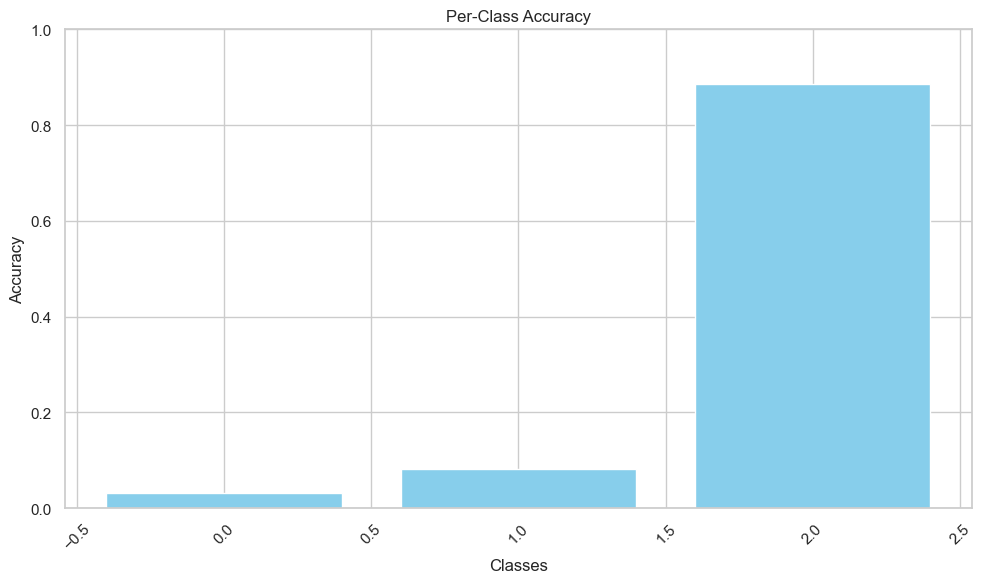


Test accuracy: 0.4430
Test log loss: 1.0561


In [14]:
from collections import Counter
most_common_class = Counter(y_val).most_common(1)[0][0]

# Calculate per-class accuracy
classes = np.unique(y_val)
per_class_accuracy = {}
for cls in classes:
    idx = (y_val == cls)
    if np.sum(idx) > 0:
        per_class_accuracy[cls] = accuracy_score(y_val[idx], y_pred[idx])
    else:
        per_class_accuracy[cls] = np.nan  # Handle classes with no samples

# Plot per-class accuracy
plt.figure(figsize=(10, 6))
plt.bar(per_class_accuracy.keys(), per_class_accuracy.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print overall metrics
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test log loss: {test_loss:.4f}')

<Figure size 20000x80000 with 0 Axes>

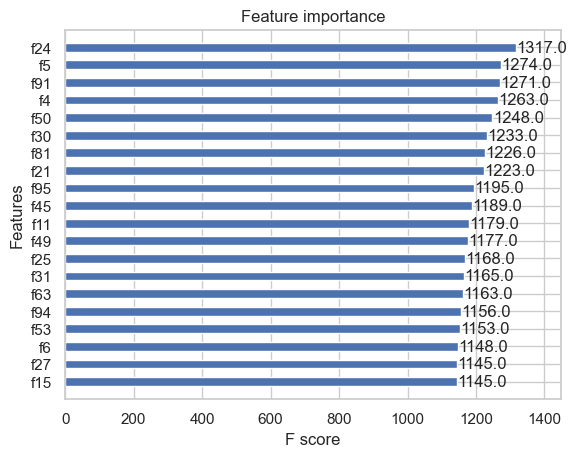

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(200, 800))
xgb.plot_importance(fourierXGBMModel, max_num_features=20, height=0.5)
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()

In [16]:
import numpy as np


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_close = scaler.fit_transform()

LSTM_X_train = fourierTestML.X_train_timeseries
LSTM_y_train = fourierTestML.y_train_timeseries
LSTM_X_test = fourierTestML.X_test_timeseries
LSTM_y_test = fourierTestML.y_test_timeseries

max_X_train = np.max(LSTM_X_train)
max_y_train = np.max(LSTM_y_train)
max_X_test = np.max(LSTM_X_test)
max_y_test = np.max(LSTM_y_test)

max_all = np.max([max_X_train, max_y_train, max_X_test, max_y_test])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(LSTM_X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

epochs = 5
batch_size = 64

history = model.fit(LSTM_X_train/max_all, LSTM_y_train/max_all, batch_size=batch_size, epochs=epochs, validation_data=(LSTM_X_test/max_all, LSTM_y_test/max_all))

LSTM_predictions = model.predict(LSTM_X_test/max_all)*max_all


Epoch 1/5


c:\Users\KILightTouch\Desktop\RandomOdyssey\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0030 - val_loss: 2.0050e-05
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 7.1212e-05 - val_loss: 1.6661e-05
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 1.5077e-05 - val_loss: 6.8975e-06
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 2.4591e-05 - val_loss: 6.7208e-06
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 3.0934e-05 - val_loss: 6.9401e-06
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [31]:
rmse = np.sqrt(np.mean(((LSTM_predictions - LSTM_y_test) ** 2)))
print(f'Root mean Square Error: {rmse}')

LSTM_y_pred_cat = []
for LSTM_y in LSTM_predictions:
    LSTM_y_pred_cat.append(fourierTestML.getTargetFromPrice(LSTM_y-1, [0.0045])[0])

LSTM_y_pred_cat = np.round(np.array(LSTM_y_pred_cat)+1)
# Calculate accuracy
test_acc = accuracy_score(fourierTestML.y_test, LSTM_y_pred_cat)

print(f'\nTest accuracy: {test_acc:.4f}')

Root mean Square Error: 0.017839671764394823

Test accuracy: 0.4396


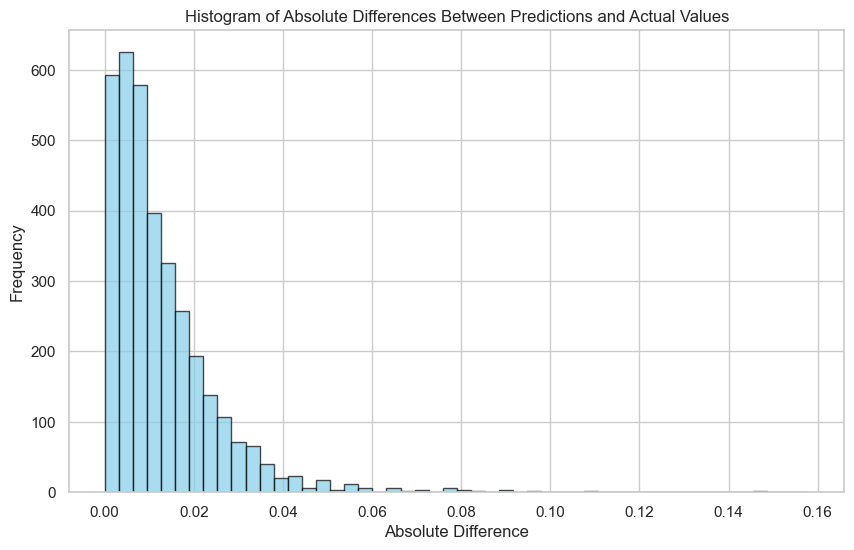

In [32]:
# Compute the absolute differences
abs_diff = np.abs((LSTM_predictions - LSTM_y_test))

# Flatten the array to 1D
abs_diff = abs_diff.flatten()

# Plot the histogram of absolute differences
plt.figure(figsize=(10,6))
plt.hist(abs_diff, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Absolute Differences Between Predictions and Actual Values')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

(3510,)
(3510,)


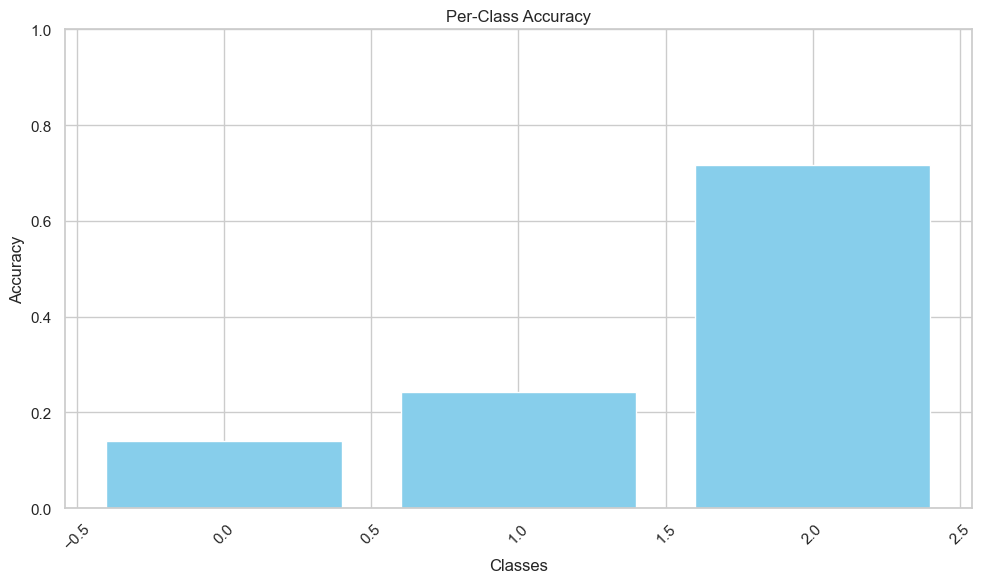

In [33]:
# Calculate per-class accuracy
classes = np.unique(fourierTestML.y_test)
lstm_per_class_accuracy = {}
LSTM_y_test_cat = np.array(fourierTestML.y_test)
print(LSTM_y_test_cat.shape)
LSTM_y_pred_cat = np.array(LSTM_y_pred_cat)
print(LSTM_y_pred_cat.shape)
for cls in classes:
    idx = (LSTM_y_test_cat == cls)
    if np.sum(idx) > 0:
        lstm_per_class_accuracy[cls] = accuracy_score(LSTM_y_test_cat[idx], LSTM_y_pred_cat[idx])
    else:
        lstm_per_class_accuracy[cls] = np.nan  # Handle classes with no samples

# Plot per-class accuracy
plt.figure(figsize=(10, 6))
plt.bar(lstm_per_class_accuracy.keys(), lstm_per_class_accuracy.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()